<a href="https://colab.research.google.com/github/SeongminCC/CNN_models/blob/main/3_GoogLenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

코드 구현 링크 : https://velog.io/@euisuk-chung/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98-%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98%EB%A1%9C-CNN-%EB%AA%A8%EB%8D%B8%EC%9D%84-%EA%B5%AC%ED%98%84%ED%95%B4%EB%B3%B4%EC%9E%90-GoogleNet%ED%8E%B8

# modules import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

from torchsummary import summary as summary_

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

  - 현재 GPU 설정

In [ ]:
torch.cuda.is_available()

True

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
device

device(type='cuda')

# 전처리 설정



In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                                transforms.Resize(225)])


# 데이터 로드 및 확인

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='/data',
                                        train=True,
                                        download=True,
                                        transform=transform)

testset = torchvision.datasets.CIFAR10(root='/data',
                                       train=False,
                                       download=True,
                                       transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(trainset,
                          batch_size=100,
                          shuffle=True,
                          num_workers=2)
test_loader = DataLoader(testset,
                         batch_size=100,
                         shuffle=True,
                         num_workers=2)

In [ ]:
for x, y in train_loader:
    print(x.shape)
    break

torch.Size([100, 3, 225, 225])


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

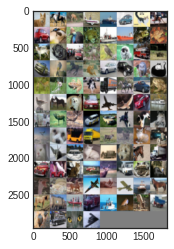

torch.Size([100, 3, 225, 225])


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, lables = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(images.shape)

# 신경망 구성

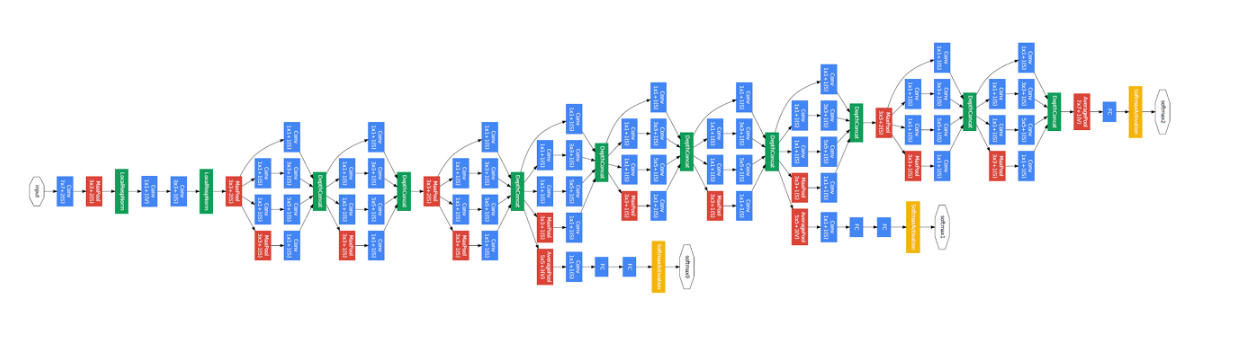

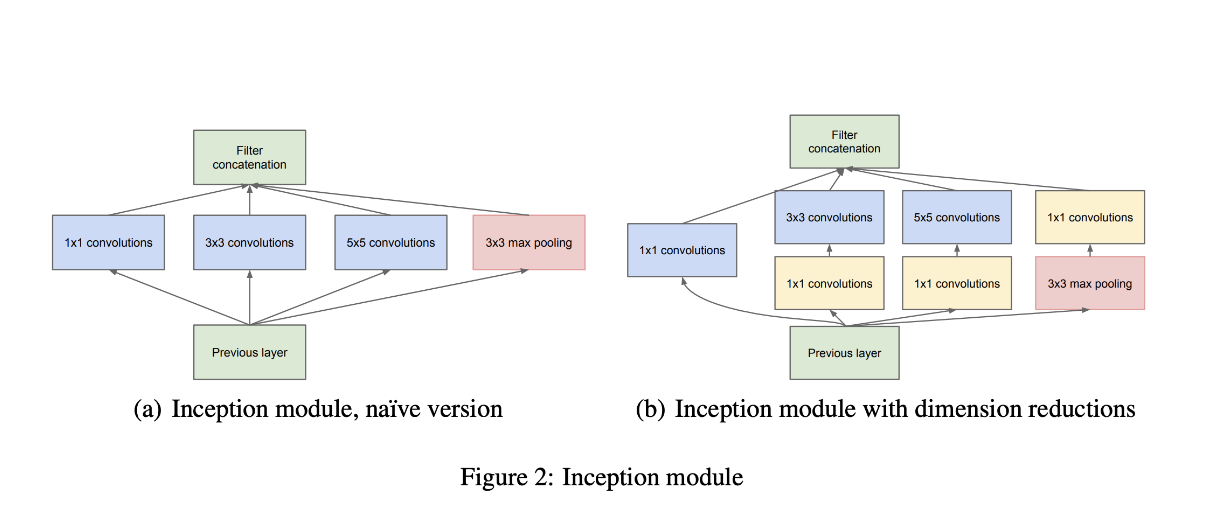

**(a) Naive Inception**
  - 위 기법은 각각 1x1, 3x3, 5x5 합성곱 연산을 수행한 뒤 각각의 결과를 concatenate해주어 다음 단계로 넘어간다.
  - 앙상블의 효과를 갖고 있어 모델이 다양한 관점으로 학습을 할 수 있도록 한다.

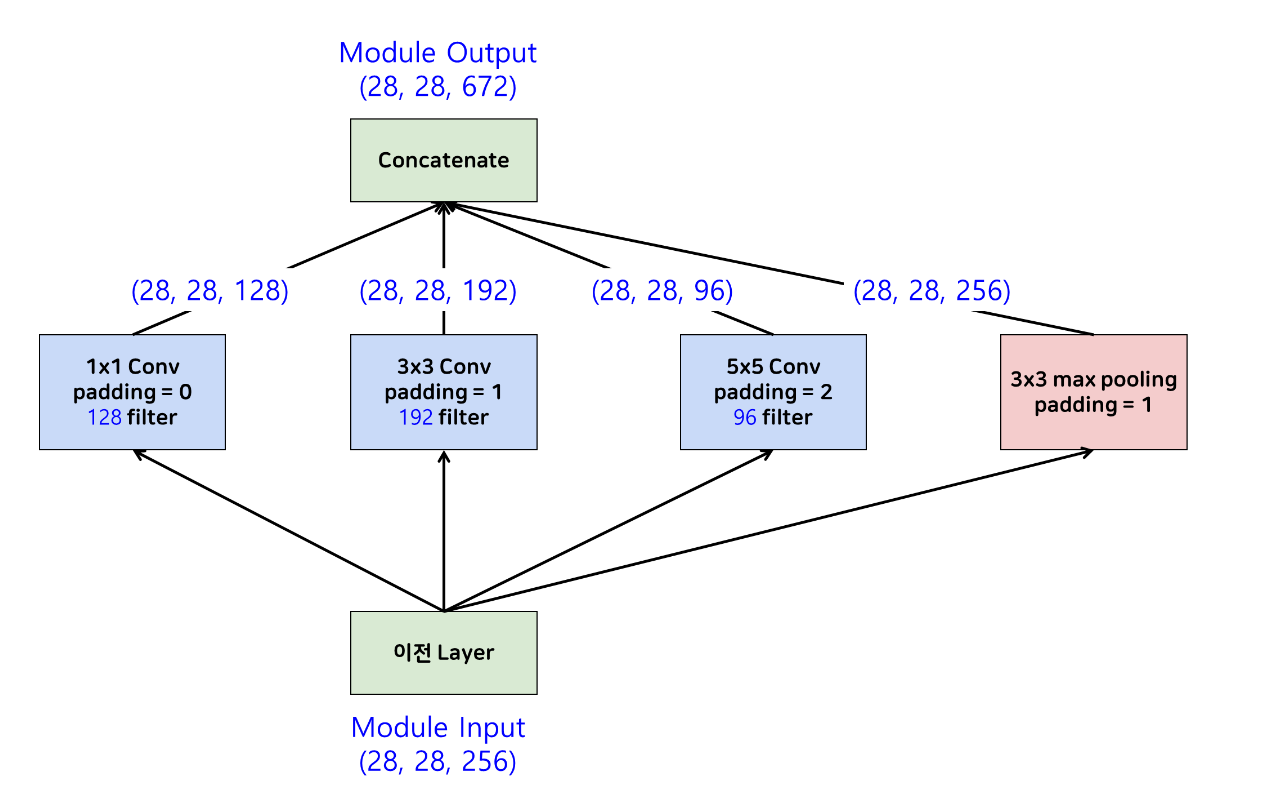

**(b) Reduced Dimension Inception**
  - 1x1 Convolution
    - 1x1 합성곱을 이용하여 계산 부화를 줄여준다.

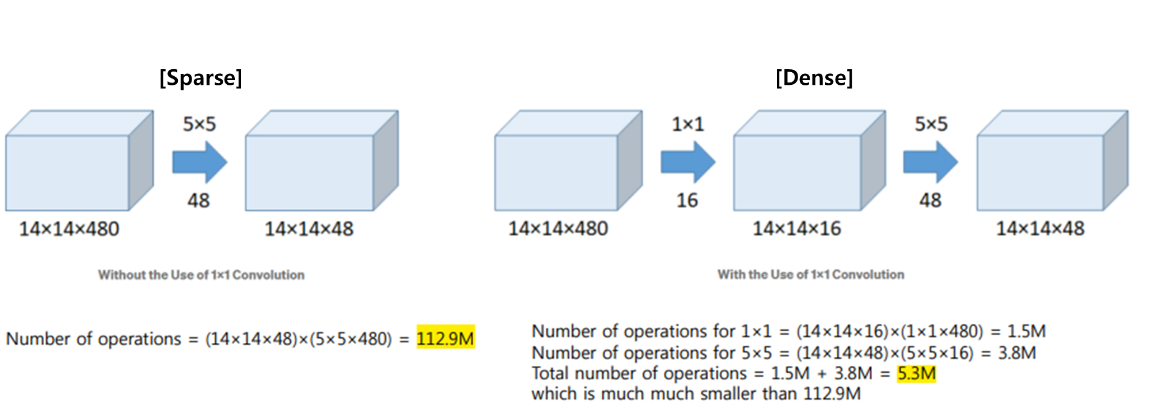

**Global Average Pooling(GAP)**
  - 지금까지의 cnn모델들 처럼 softmax 연산을 하기위해 flatten을 시켜주는 작업은 굉장히 많은 파라미터를 필요로 하며, 기존 featuremap의 공간적 정보도 많이 잃어버리게 된다.(VGGNet의 계산량이 많은 이유도 이 때문)
  - 이를 위해 GAP기법이 사용된다.

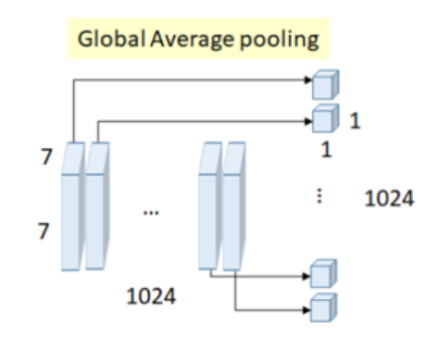


**GAP는 각 feature map 안에 있는 특징값들의 평균을 각각의 출력 노드에 입력하는 방식**
  - 바로 평균을 취하기 때문에 필요한 Weight의 개수가 0개가 된다.

**Auxiliary Classifier**
  - Neural Network의 모델이 깊어질수록 vanishing gradient의 문제가 생기는 것을 방지하기 위해 사용한 기법
  - 모델의 맨 마지막 layer에만 softmax를 놓지 않고, 중간중간에 추가적인 classifier을 정의하여 중간에서도 역전파가 진행되도록 한다.
  - backpropagation을 하는 동안 weight값에 영향이 크게 가지 않도록 Auxiliary Classifier에 0.3을 곱하여 training을 한다.
  - Auxiliary Classifier은 학습 시 발생하는 문제인 vanishing gradient만을 해결하기 위해 사용하는 기법이므로 test할 때는 빼고 마지막 layer에 있는 softmax만을 이용한다.

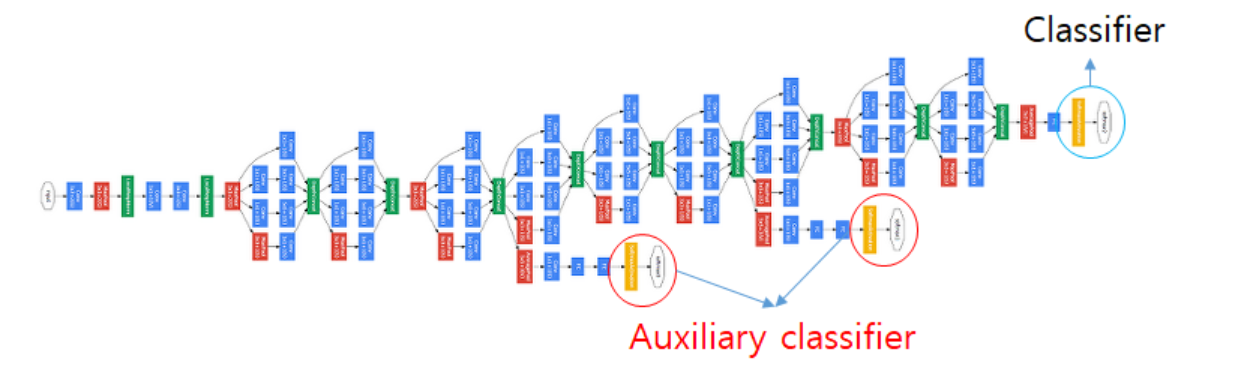

# 코드 구현

**각각의 합성곱 묶음들을 함수로 정의**

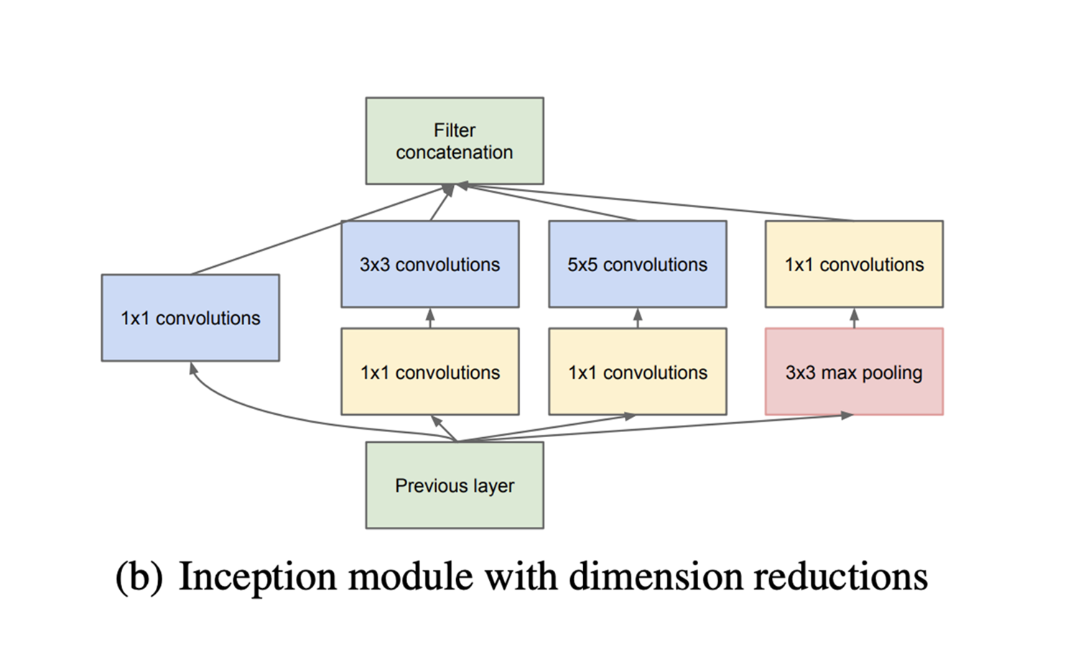

In [ ]:
# 1x1 Convolution
def conv_1(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU()
    )
    return model

# 1x1 Convolution -> 3x3 Convolution
def conv_1_3(in_dim, mid_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, mid_dim, 1, 1),
        nn.BatchNorm2d(mid_dim),
        nn.ReLU(),
        nn.Conv2d(mid_dim, out_dim, 3, 1, padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU()
    )
    return model

# 1x1 Convolution -> 5x5 Convolution
def conv_1_5(in_dim, mid_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, mid_dim, 1, 1),
        nn.BatchNorm2d(mid_dim),
        nn.ReLU(),
        nn.Conv2d(mid_dim, out_dim, 5, 1, padding=2),
        nn.BatchNorm2d(out_dim),
        nn.ReLU()
    )
    return model

# 3x3 MaxPooling -> 1x1 Convolution

def max_3_1(in_dim, out_dim):
    model = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        nn.Conv2d(in_dim, out_dim, 1, 1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU()
    )
    return model

**Inception module 정의하기**
  - 위에 정의한 함수들을 이용해서 concat하는 단계
  

In [ ]:
class inception_module(nn.Module):
    def __init__(self, in_dim, out_dim_1, mid_dim_3, out_dim_3, mid_dim_5, out_dim_5, pool_dim):
        super(inception_module, self).__init__()
        # 1x1 Convolution
        self.conv_1 = conv_1(in_dim, out_dim_1)

        # 1x1 Convolution -> 3x3 Convolution
        self.conv_1_3 = conv_1_3(in_dim, mid_dim_3, out_dim_3)

        # 1x1 Convolution -> 5x5 Convolution
        self.conv_1_5 = conv_1_5(in_dim, mid_dim_5, out_dim_5)

        # 3x3 MaxPooling -> 1x1 Convolution
        self.max_3_1 = max_3_1(in_dim, pool_dim)

    def forward(self, x):
        out_1 = self.conv_1(x)
        out_2 = self.conv_1_3(x)
        out_3 = self.conv_1_5(x)
        out_4 = self.max_3_1(x)
        # concat
        output = torch.cat([out_1,out_2,out_3,out_4], dim=1)  # 가로 방향(dim=1)으로 합치기
        return output

**GoogLeNet 정의하기**

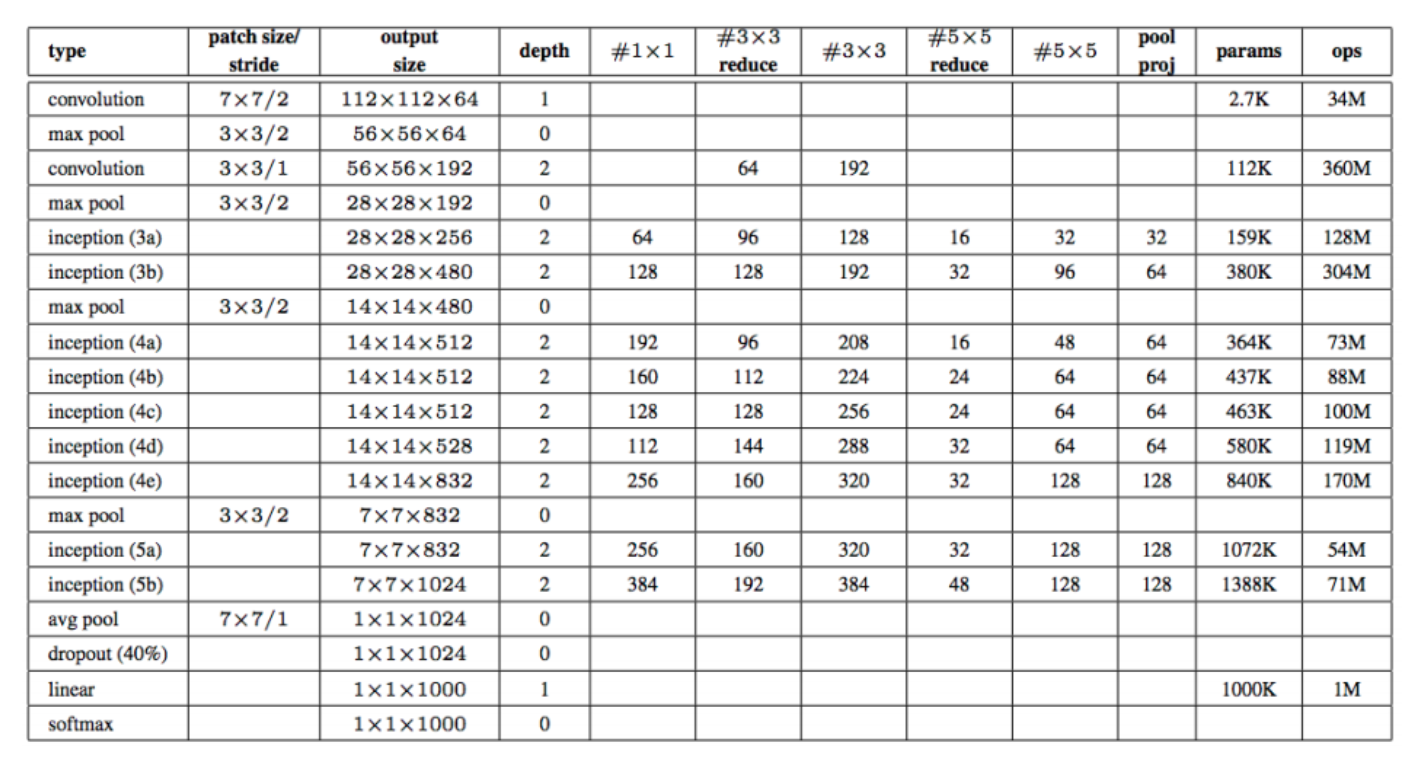

In [ ]:
class GoogLeNet(nn.Module):
    def __init__(self, base_dim=64, num_classes=10):
        super(GoogLeNet, self).__init__()
        self.num_classes=num_classes
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3, base_dim, 7, 2, 3),
            nn.BatchNorm2d(base_dim),
            nn.MaxPool2d(3, 2, 1),
            nn.Conv2d(base_dim, base_dim*3, 3, 1, 1),
            nn.BatchNorm2d(base_dim*3),
            nn.MaxPool2d(3, 2, 1)
        )
        self.layer_2 = nn.Sequential(
            inception_module(base_dim*3, 64, 96, 128, 16, 32, 32),
            inception_module(base_dim*4, 128, 128, 192, 32, 96, 64),
            nn.MaxPool2d(3, 2, 1)
        )
        self.layer_3 = nn.Sequential(
            inception_module(480, 192, 96, 208, 16, 48, 64),
            inception_module(512, 160, 112, 224, 24, 64, 64),
            inception_module(512, 128, 128, 256, 24, 64, 64),
            inception_module(512, 112, 144, 288, 32, 64, 64),
            inception_module(528, 256, 160, 320, 32, 128, 128),
            nn.MaxPool2d(3,2,1)
        )
        self.layer_4 = nn.Sequential(
            inception_module(832, 256, 160, 320, 32, 128, 128),
            inception_module(832, 384, 192, 384, 48, 128, 128),
            nn.AvgPool2d(8, 1)
        )
        self.layer_5 = nn.Dropout2d(p=0.4)
        self.fc_layer = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.layer_5(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out


net = GoogLeNet().to(device)
print(net)

GoogLeNet(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): inception_module(
      (conv_1): Sequential(
        (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv_1_3): Sequential(
        (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2)

# 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0002, momentum=0.9)

In [ ]:
file_name = 'GoogLeNet_cifar10.pth'

In [ ]:
def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += labels.size(0)
        current_correct = (predicted == labels).sum().item()
        correct += current_correct

        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current batch average train accuracy:', current_correct / labels.size(0))
            print('Current batch average train loss:', loss.item() / labels.size(0))            
            

# 훈련이 모두 끝난 후 정확도 / 솔실함수 값을 출력  
    print('\nTotal average train accuarcy:', correct / total)
    print('Total average train loss:', train_loss / total)

def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            total += labels.size(0)

            outputs = net(inputs)
            loss += criterion(outputs, labels).item()

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()

        print('\nTotal average test accuarcy:', correct / total)
        print('Total average test loss:', loss / total)

        state = {
            'net' : net.state_dict()
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/' + file_name)
        print('Model Saved!')

In [ ]:
import time
import os

start_time = time.time()

for epoch in range(0, 10):
    train(epoch)
    test(epoch)
    print('\tTime elapsed:', time.time()-start_time)


[ Train epoch: 0 ]

Current batch: 0
Current batch average train accuracy: 0.11
Current batch average train loss: 0.023369388580322267

Current batch: 100
Current batch average train accuracy: 0.23
Current batch average train loss: 0.02091552734375

Current batch: 200
Current batch average train accuracy: 0.3
Current batch average train loss: 0.019841848611831664

Current batch: 300
Current batch average train accuracy: 0.32
Current batch average train loss: 0.01898141622543335

Current batch: 400
Current batch average train accuracy: 0.33
Current batch average train loss: 0.01811391592025757

Total average train accuarcy: 0.29978
Total average train loss: 0.01909474354982376

[ Test epoch: 0 ]

Total average test accuarcy: 0.4306
Total average test loss: 0.01582820773124695
Model Saved!
	Time elapsed: 279.5222225189209

[ Train epoch: 1 ]

Current batch: 0
Current batch average train accuracy: 0.3
Current batch average train loss: 0.01635571599006653

Current batch: 100
Current batch

**Test Accuracy : 72.33%**

**Test Loss : 0.00800**

**걸린 시간 : 약 40분**